# Explorando la API de DBLP: Introducción y objetivos

## ¿Qué es DBLP?
DBLP es una base de datos bibliográfica en línea que proporciona información sobre publicaciones científicas, principalmente en el ámbito de la informática. Esta API permite acceder a datos estructurados sobre artículos, autores y conferencias, facilitando la búsqueda y el análisis de publicaciones académicas.

[Sitio web oficial de DBLP](https://dblp.org/)

---

- ¿Qué problemas puede enfrentar una API si no establece límites de consumo?
- ¿Cómo podría afectar esto a los usuarios finales o a los desarrolladores?

---



## ¿Cómo consumiríamos la API sin una especificación clara?
La API de DBLP no tiene una especificación formal sobre sus límites de consumo (*rate limits*) o cuotas. Sin embargo, en el siguiente [FAQ de DBLP](https://dblp.org/faq/Am+I+allowed+to+crawl+the+dblp+website.html), se indica que las solicitudes deben espaciarse cada 2 segundos. Seguimos sin un límite claro de solicitudes por minuto, pero tras realizar pruebas, se ha observado que el límite asumible es de **10 solicitudes por minuto**.

Vamos a probar un consumo regulado durante **1 minuto**, espaciando las solicitudes cada 3 segundos. Si el límite asumido de **10 solicitudes por minuto** es correcto, no deberíamos obtener errores 429.

In [1]:
import logging
from Pricing4API.ancillary.limit import Limit
from Pricing4API.ancillary.time_unit import TimeDuration, TimeUnit
from Pricing4API.main.new_plan import Plan
from Pricing4API.main.new_subscription import Subscription

In [10]:




logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')


plan_dblp = Plan('DBLP', (0.0, TimeDuration(1, TimeUnit.MONTH)), overage_cost=None, unitary_rate=Limit(1, TimeDuration(2.5, TimeUnit.SECOND)),
                 quotes=[Limit(10, TimeDuration(1, TimeUnit.MINUTE))])






In [11]:
dblp_subscription = Subscription(plan_dblp, 'https://dblp.org/search/publ/api')

2025-01-07 19:44:33,939 - Subscription to https://dblp.org/search/publ/api started at 1736275473.9381058


In [13]:
dblp_subscription.api_usage_simulator(TimeDuration(5, TimeUnit.MINUTE))

2025-01-07 19:45:36,028 - Valid request (1) to https://dblp.org/search/publ/api
2025-01-07 19:45:36,031 - Waiting 2.5 s
2025-01-07 19:45:38,762 - Valid request (2) to https://dblp.org/search/publ/api
2025-01-07 19:45:38,763 - Waiting 2.5 s
2025-01-07 19:45:41,490 - Valid request (3) to https://dblp.org/search/publ/api
2025-01-07 19:45:41,491 - Waiting 2.5 s
2025-01-07 19:45:44,219 - Valid request (4) to https://dblp.org/search/publ/api
2025-01-07 19:45:44,221 - Waiting 2.5 s
2025-01-07 19:45:47,014 - Valid request (5) to https://dblp.org/search/publ/api
2025-01-07 19:45:47,015 - Waiting 2.5 s
2025-01-07 19:45:49,827 - Valid request (6) to https://dblp.org/search/publ/api
2025-01-07 19:45:49,827 - Waiting 2.5 s
2025-01-07 19:45:52,498 - Valid request (7) to https://dblp.org/search/publ/api
2025-01-07 19:45:52,500 - Waiting 2.5 s
2025-01-07 19:45:55,169 - Valid request (8) to https://dblp.org/search/publ/api
2025-01-07 19:45:55,170 - Waiting 2.5 s
2025-01-07 19:45:57,849 - Valid request 

KeyboardInterrupt: 

Al ejecutar esta simulación, hemos observado que el comportamiento real de la API varía:

- Aunque asumimos una cuota de **20 solicitudes por minuto**, la API suele responde con errores 429 a partir de la solicitud número 12. Esto sugiere que la cuota real es más restrictiva.
---

Tras pruebas decarga, hemos podido deducir los siguientes límites:
1. **1 llamada cada 10 segundos:** Este límite asegura que las solicitudes se espacien lo suficiente para evitar sobrecargar el servidor.
2. **6 llamadas por minuto:** Este límite se deduce de la cuota de 1 llamada cada 10 segundos. Si se mantiene un ritmo constante, se pueden realizar 6 llamadas por minuto.

In [2]:

plan_dblp = Plan('DBLP', (0.0, TimeDuration(1, TimeUnit.MONTH)), overage_cost=None, unitary_rate=Limit(1, TimeDuration(2, TimeUnit.SECOND)), quotes=[Limit(20, TimeDuration(1, TimeUnit.MINUTE))])
dblp_subscription = Subscription(plan_dblp, 'https://dblp.org/search/publ/api')

2025-01-07 20:24:05 - root - INFO - Subscription to https://dblp.org/search/publ/api started at 1736277845.3798358


In [3]:
plan_dblp.max_quota_burning_time.to_seconds()

38.0

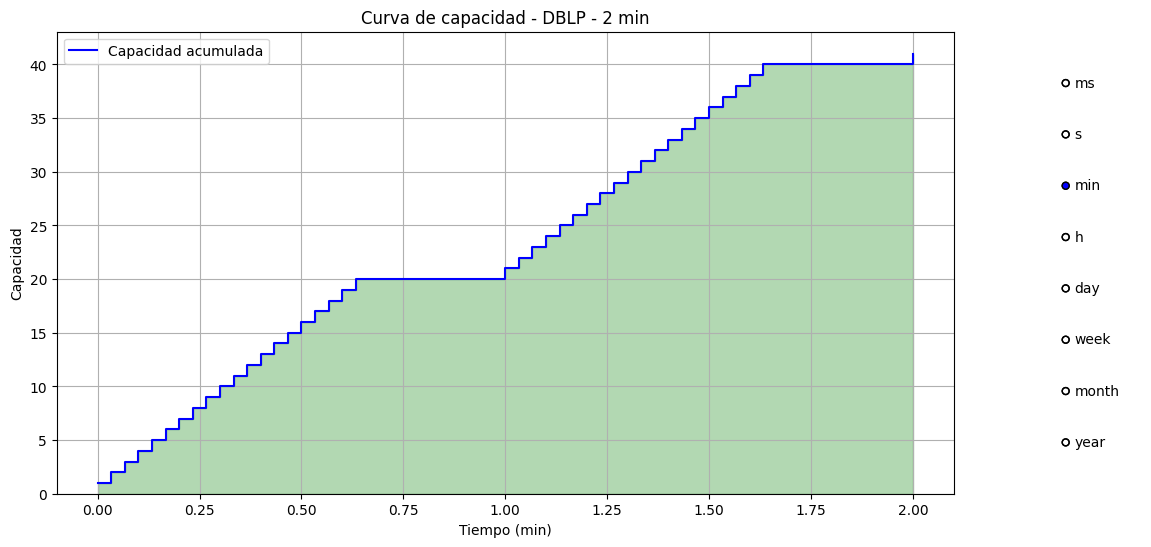

In [4]:
plan_dblp.show_available_capacity_curve(TimeDuration(2, TimeUnit.MINUTE))

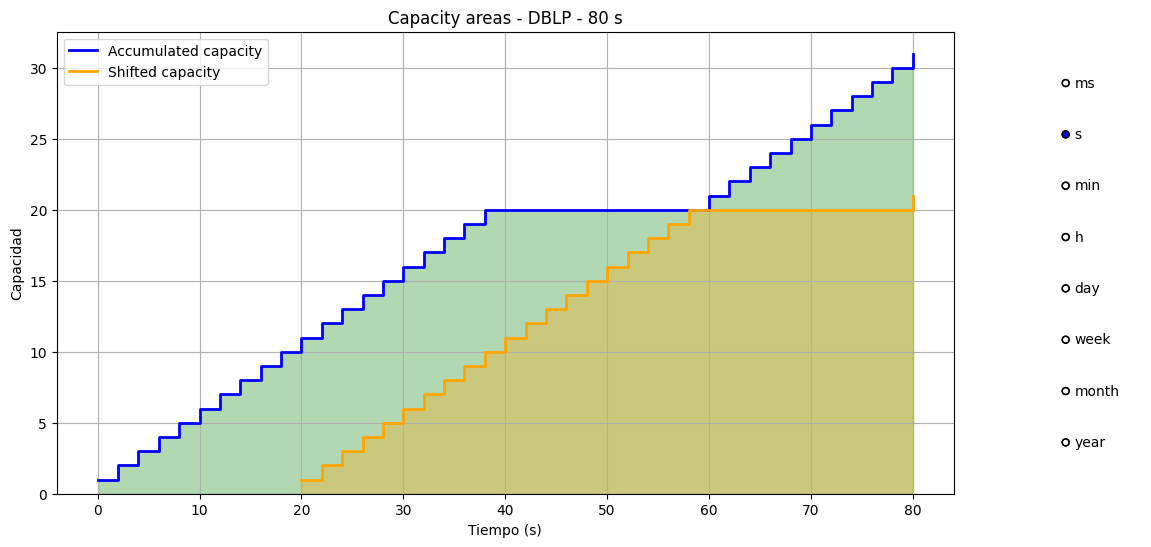

In [5]:
plan_dblp.show_capacity_areas(TimeDuration(80, TimeUnit.SECOND))

Definir la vigencia de un Pricing y la documentación actualizada son aspectos claves para garantizar un consumo adecuado de la API.

- El primer código de prueba fue desarrollado hace **12 meses** y asumía un límite de **20 solicitudes por minuto**, que ya no es válido.
- Sin una especificación clara y actualizada, los desarrolladores deben deducir los límites mediante pruebas, lo que puede generar ineficiencias y errores.



## Regulado vs. No regulado

Cuando la suscripción está regulada, el simulador respeta los límites establecidos en el plan, asegurando que no aparezcan errores `429 Too Many Requests`.

Sin embargo, si marcamos la suscripción como no regulada, el simulador intentará realizar las solicitudes tan rápido como sea posible, ignorando los límites establecidos. En este caso, observaremos errores `429` en pocos segundos, ya que la API detectará el exceso de consumo.

In [ ]:
import time
dblp_subscription.regulated(False)

dblp_subscription.api_usage_simulator(TimeDuration(10, TimeUnit.SECOND))

# La cabecera nos indica un Retry-After de 300 segundos.

time.sleep(300)

dblp_subscription.regulated(True)

dblp_subscription.api_usage_simulator(TimeDuration(1, TimeUnit.MINUTE))

---

## ¿Cuántas solicitudes puedes hacer?

Basándonos en lo que sabemos sobre la API, intenta responder a las siguientes preguntas. Usa los valores de **rate** y **cuota** para responder:

1. ¿Cuántas solicitudes se pueden hacer en:
   - 10 segundos?
   - 1 minuto?
   - 10 minutos?
   - 10 minutos y 30 segundos?

---

Para responder con precisión a estas preguntas, necesitamos una función que calcule el número máximo de solicitudes permitidas en un período \( t \), respetando tanto el **rate** como la **cuota** del plan.


### Ejercicio: Implementar capacity(t)

In [3]:
# habría que dar acceso a las props de plan o algo, lo dejamos en TODO


def capacity(plan, t):
    pass


La función `capacity(t)` ya está implementada en la clase `Plan`. Vamos a probarla en distintos escenarios:

In [2]:
time_simulation_10s = TimeDuration(10, TimeUnit.SECOND)
time_simulation_1m = TimeDuration(1, TimeUnit.MINUTE)
time_simulation_1min_9s = TimeDuration(1, TimeUnit.MINUTE) + TimeDuration(9, TimeUnit.SECOND)

capacity_10s = plan_dblp.available_capacity(time_simulation_10s, len(plan_dblp.limits) - 1)
capacity_1m = plan_dblp.available_capacity(time_simulation_1m, len(plan_dblp.limits) - 1)
capacity_1min_9s = plan_dblp.available_capacity(time_simulation_1min_9s, len(plan_dblp.limits) - 1)

print(f"Capacidad en 10 segundos: {capacity_10s}")
print(f"Capacidad en 1 minuto: {capacity_1m}")
print(f"Capacidad en 1 minuto y 9 segundos: {capacity_1min_9s}")

NameError: name 'TimeDuration' is not defined

## ¿Cuánto tiempo necesitas para hacer X solicitudes?

Usando los límites de la API (rate y cuota), intenta calcular cuánto tiempo tomaría realizar las siguientes solicitudes. Piensa si el rate o la cuota influirán más en el resultado:

1. ¿Cuánto tiempo necesitas para realizar:
   - 10 solicitudes?
   - 20 solicitudes?
   - 100 solicitudes?

---

Para responder estas preguntas, necesitamos una función, que calcule el tiempo mínimo necesario para realizar un número dado de solicitudes, respetando tanto el **rate** como la **cuota** del plan.

### Ejercicio: min_time(capacity_goal)

In [ ]:
# habría que dar acceso a las props de plan o algo, lo dejamos en TODO


def min_time(plan, capacity_goal):
    pass


La función `min_time(capacity_goal)` ya está implementada en la clase `Plan`. Vamos a probarla en distintos escenarios:

In [ ]:
# Tiempo necesario para realizar 10, 20 y 100 solicitudes
time_10_requests = plan_dblp.min_time(10)
time_20_requests = plan_dblp.min_time(20)
time_100_requests = plan_dblp.min_time(100)

print(f"Tiempo para 10 solicitudes: {time_10_requests}")
print(f"Tiempo para 20 solicitudes: {time_20_requests}")
print(f"Tiempo para 100 solicitudes: {time_100_requests}")

## Curva de Capacidad

Para facilitar la comprensión de la API bajo los límites de capacidad vamos a generar una gráfica que muestra:

- **Capacidad acumulada**: Número máximo de solicitudes permitidas en un período \( t \).
- **Tiempo mínimo**: Tiempo necesario para realizar un número dado de solicitudes.

---

¿Qué observas en la gráfica? ¿Cómo se relacionan la capacidad acumulada y el tiempo mínimo necesario para realizar un número dado de solicitudes?


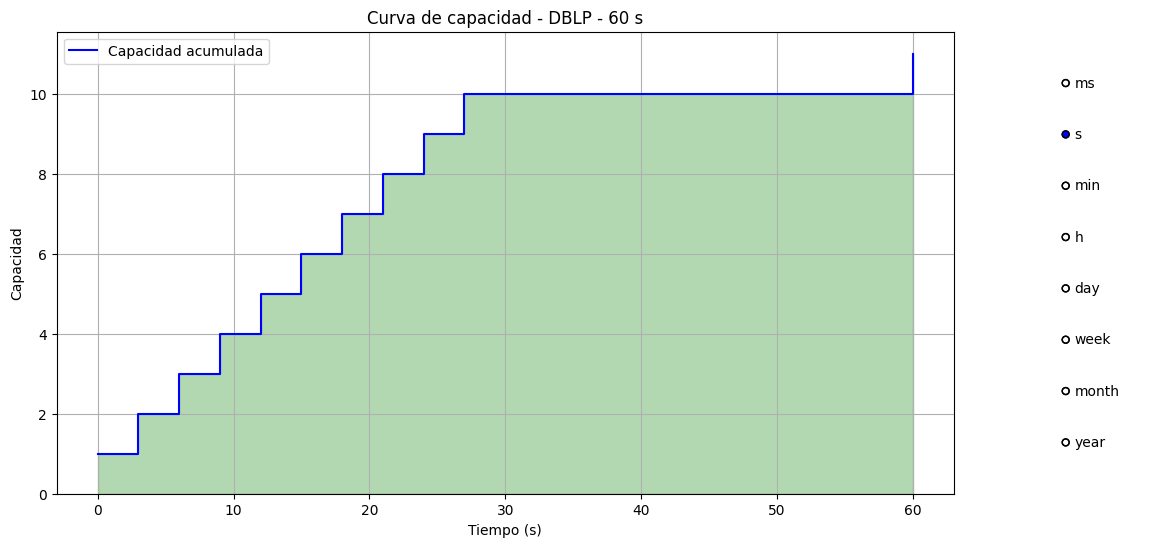

In [16]:
time_interval = TimeDuration(60, TimeUnit.SECOND)

plan_dblp.show_available_capacity_curve(time_interval)

In [7]:
'''
Como la cuota mas restrictiva se infiere del rate, si quieres ser eficiente tienes que empezar a consumir en el momento 0. Por tanto el área de pérdida sería
el mismo área que la propia curva de capacidad.

Decidir si:
- Se deja para otro notebook ese concepto
- Se introduce una cuota más restrictiva que no se infiera del rate, y mostramos el área de pérdida a partir del t = quote_frequency[-1] - MQRI 
'''


'\nComo la cuota mas restrictiva se infiere del rate, si quieres ser eficiente tienes que empezar a consumir en el momento 0. Por tanto el área de pérdida sería\nel mismo área que la propia curva de capacidad.\n\nDecidir si:\n- Se deja para otro notebook ese concepto\n- Se introduce una cuota más restrictiva que no se infiera del rate, y mostramos el área de pérdida a partir del t = quote_frequency[-1] - MQRI \n'